# **feature selection**

dropping irrelevant columns

In [10]:
df.drop(columns=['Arrival_Time','Additional_Info','Route'],inplace=True)
df.head()

,Airline,Date_of_Journey,Source,Destination,Dep_Time,Duration,Total_Stops,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,22:20,2h 50m,non-stop,3897
1,Air India,1/05/2019,Kolkata,Banglore,05:50,7h 25m,2 stops,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,09:25,19h,2 stops,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,18:05,5h 25m,1 stop,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,16:50,4h 45m,1 stop,13302


# ***handelling date/time***

* 'Date_of_Journey' into day of week
* 'dep_hour' into departure hour

In [12]:
df['clean_date'] = pd.to_datetime(df['Date_of_Journey'], format='%d/%m/%Y', errors='coerce')
df['clean_deptime']=pd.to_datetime(df['Dep_Time'],format='%H:%M',errors='coerce')

df['day_of_week'] = df['clean_date'].dt.day_name()
df['dep_hour']=df['clean_deptime'].dt.hour
df.drop(columns=['Date_of_Journey','clean_date','clean_deptime'],inplace=True)


In [15]:
df.drop(index=9039, inplace=True)

In [17]:
temp_duration = df['Duration'].str.replace('h', ' hours').str.replace('m', ' minutes')

df['Duration_Delta'] = pd.to_timedelta(temp_duration)

df['Duration_hours'] = df['Duration_Delta'].dt.total_seconds() / 3600
df.drop(columns=['Dep_Time','Duration','Duration_Delta'],inplace=True)

In [18]:
df.drop(columns=['Dep_Time','Duration','Duration_Delta'],inplace=True)
df.head()

,Airline,Source,Destination,Total_Stops,Price,day_of_week,dep_hour,Duration_hours
0,IndiGo,Banglore,New Delhi,non-stop,3897,Sunday,22,2.833333
1,Air India,Kolkata,Banglore,2 stops,7662,Wednesday,5,7.416667
2,Jet Airways,Delhi,Cochin,2 stops,13882,Sunday,9,19.000000
3,IndiGo,Kolkata,Banglore,1 stop,6218,Sunday,18,5.416667
4,IndiGo,Banglore,New Delhi,1 stop,13302,Friday,16,4.750000


# **splitting**

In [19]:
from sklearn.model_selection import train_test_split

x = df.iloc[:, [0, 1, 2, 3, 5, 6, 7]]
y = df.iloc[:, 4]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_train.info()
x_train.head()

,Airline,Source,Destination,Total_Stops,day_of_week,dep_hour,Duration_hours
10005,Multiple carriers,Delhi,Cochin,1 stop,Monday,8,10.750000
3684,Jet Airways,Delhi,Cochin,1 stop,Thursday,11,25.083333
1034,SpiceJet,Delhi,Cochin,1 stop,Wednesday,15,6.333333
3909,Multiple carriers,Delhi,Cochin,1 stop,Thursday,12,12.750000
3088,Air India,Delhi,Cochin,2 stops,Monday,17,26.000000


# ***transformations***

visualizing the data

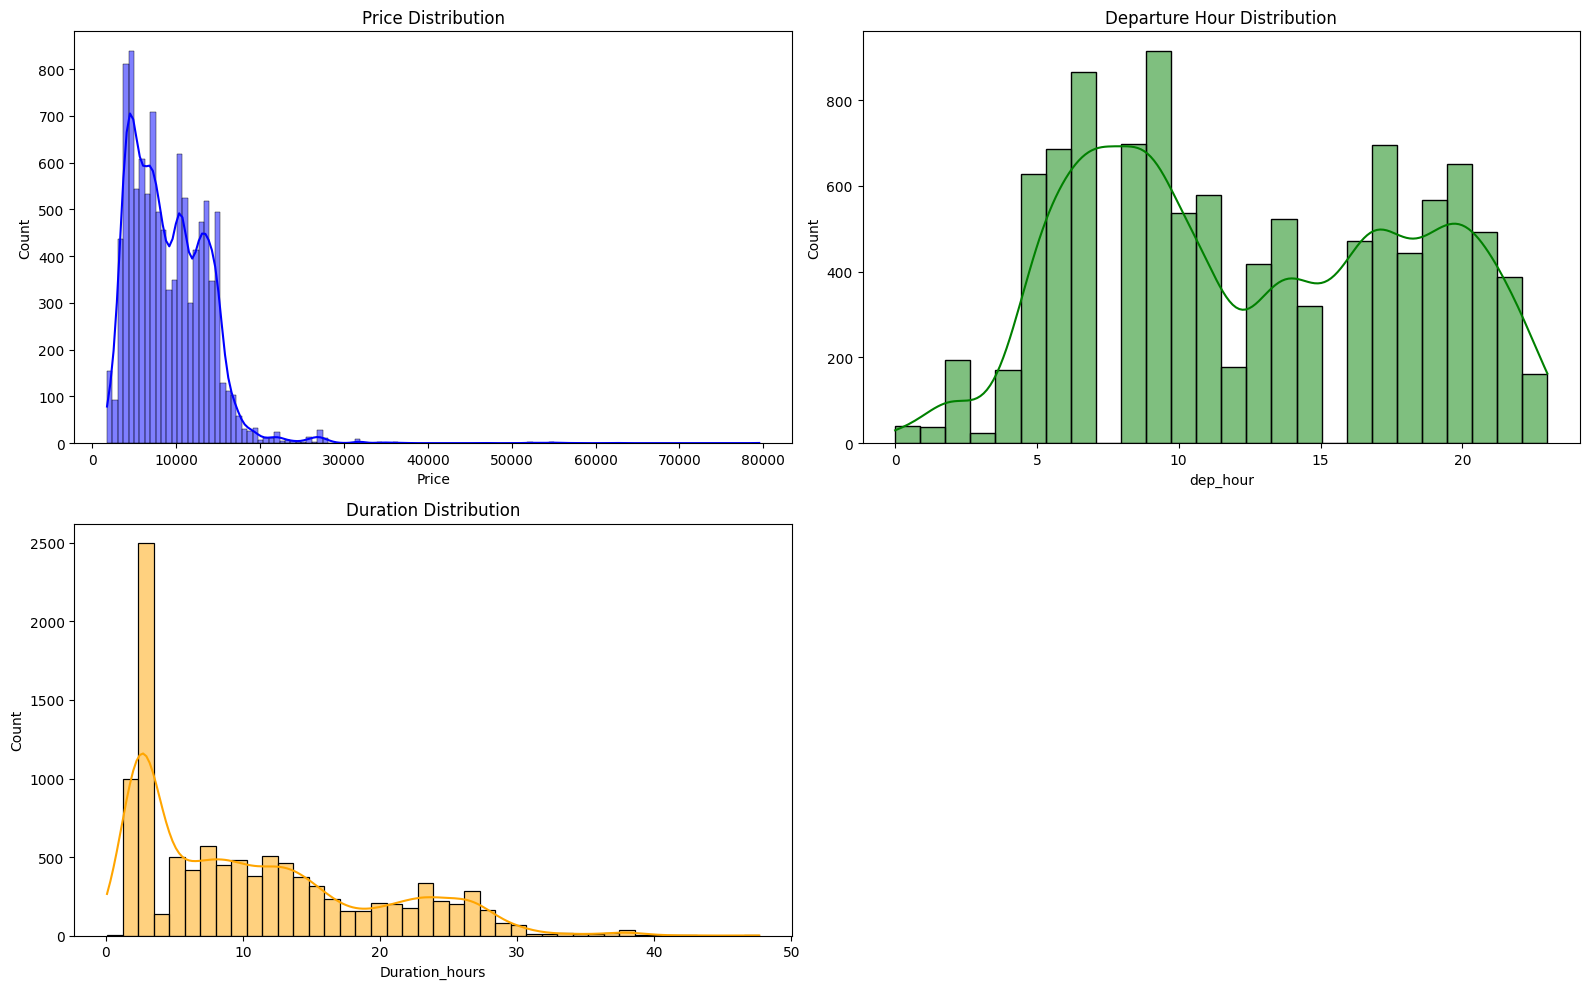

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16, 10))

plt.subplot(2, 2, 1)
sns.histplot(df['Price'], kde=True, color='blue')
plt.title('Price Distribution')

plt.subplot(2, 2, 2)
sns.histplot(df['dep_hour'], kde=True, color='green')
plt.title('Departure Hour Distribution')

plt.subplot(2, 2, 3)
sns.histplot(df['Duration_hours'], kde=True, color='orange')
plt.title('Duration Distribution')

plt.tight_layout()
plt.show()

applying transformations to price,duration  and dept_hour

#  Feature Engineering Strategy



1. **Log Transformation (Duration)**: The flight duration is significantly **right-skewed**.
2. **One-Hot Encoding (Categorical Data)**: For features like `Airline` and `Source`, there is no inherent ranking.
3. **Power Transformation (Departure Hours)**:  (Yeo-Johnson) to stabilize the variance and minimize skewness.
4. **Ordinal Encoding (Total Stops)**:  `Total_Stops` has a natural, meaningful sequence/order.


In [26]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import OneHotEncoder,MinMaxScaler,OrdinalEncoder
transformer1=FunctionTransformer(func=np.log1p,feature_names_out='one-to-one')
transformer2=PowerTransformer(method='yeo-johnson')
tranformer=ColumnTransformer(transformers=[
    ('encoding',OneHotEncoder(sparse_output=False,drop='first'),[0,1,2,4]),
    ('func',transformer1,[6]),
    ('pow',transformer2,[5]),
    ('ord_enc',OrdinalEncoder(categories=[['non-stop','1 stop', '2 stops', '3 stops', '4 stops']]),[3])
],remainder='passthrough')

x_train=tranformer.fit_transform(x_train)
x_test=tranformer.transform(x_test)


In [27]:
x_train.shape

(8545, 29)

applying log transform on price(y) as it is right skewed

In [28]:
y_train=transformer1.fit_transform(y_train.values)
y_test=transformer1.transform(y_test.values)

# visualizing new

In [32]:
import pandas as pd

new_column_names = tranformer.get_feature_names_out()

x_train_final = pd.DataFrame(x_train, columns=new_column_names)

x_train_final.head()

,encoding__Airline_Air India,encoding__Airline_GoAir,encoding__Airline_IndiGo,encoding__Airline_Jet Airways,encoding__Airline_Jet Airways Business,encoding__Airline_Multiple carriers,encoding__Airline_Multiple carriers Premium economy,encoding__Airline_SpiceJet,encoding__Airline_Trujet,encoding__Airline_Vistara,...,encoding__Destination_New Delhi,encoding__day_of_week_Monday,encoding__day_of_week_Saturday,encoding__day_of_week_Sunday,encoding__day_of_week_Thursday,encoding__day_of_week_Tuesday,encoding__day_of_week_Wednesday,func__Duration_hours,pow__dep_hour,ord_enc__Total_Stops
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.463853,-0.731177,1.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.261297,-0.179197,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.992430,0.491686,1.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.621039,-0.005479,1.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3.295837,0.806424,2.0


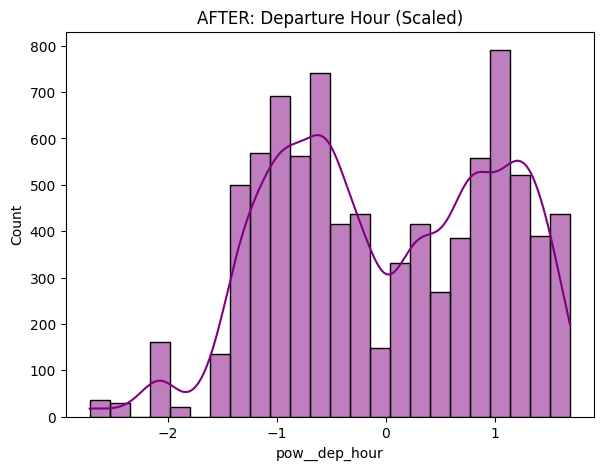

In [47]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 2)

hour_col = x_train_final.filter(like='dep_hour').columns[0]
sns.histplot(x_train_final[hour_col], kde=True, color='purple')
plt.title("AFTER: Departure Hour (Scaled)")

plt.show()

No change in dept hour was noticed

# **Prediction**

In [54]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, mean_absolute_error

models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(),
    'KNN': KNeighborsRegressor()
}

for name, model in models.items():
    model.fit(x_train, y_train)

    y_pred = model.predict(x_test)

    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    print(f"--- {name} ---")
    print(f"R2 Score: {r2:.4f}")
    print(f"Mean Absolute Error: {mae:.2f}")
    print("-" * 20)

--- Linear Regression ---
R2 Score: 0.7225
Mean Absolute Error: 0.21
--------------------
--- Random Forest ---
R2 Score: 0.7677
Mean Absolute Error: 0.17
--------------------
--- KNN ---
R2 Score: 0.7603
Mean Absolute Error: 0.19
--------------------
